<a href="https://colab.research.google.com/github/MuradovMaks/Prediction-of-Boxing-Matches/blob/main/%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5%20%D0%BF%D0%BE%D0%B1%D0%B5%D0%B4%D0%B8%D1%82%D0%B5%D0%BB%D1%8F%20%D0%B2%20%D0%B1%D0%BE%D0%BA%D1%81%D0%B5%D1%80%D1%81%D0%BA%D0%B8%D1%85%20%D0%BC%D0%B0%D1%82%D1%87%D0%B0%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предсказание боксерских матчей как по победителю,так  и по результату боя


In [1]:
#Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from requests import get
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
#Разархивируем датасет
!unzip -qo "archive.zip" -d ./the_boxing_matches_dataset

# Папка с распакованным датасетом
FILE_PATH = './the_boxing_matches_dataset'

In [3]:
#Количество файлов
import os

os.listdir(FILE_PATH)

['fighters.csv', 'popular_matches.csv']

In [4]:
df_f = pd.read_csv(f'{FILE_PATH}/fighters.csv')
df_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2764 entries, 0 to 2763
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     2764 non-null   object
 1   wins     2764 non-null   int64 
 2   looses   2764 non-null   int64 
 3   draws    2764 non-null   int64 
 4   ko_rate  2764 non-null   object
 5   stance   2764 non-null   object
 6   age      2764 non-null   object
 7   height   2764 non-null   object
 8   reach    2764 non-null   object
 9   country  2764 non-null   object
dtypes: int64(3), object(7)
memory usage: 216.1+ KB


In [5]:
#Удалим страны ,т.к они нам не интересны
df_f = df_f.drop('country',axis=1)

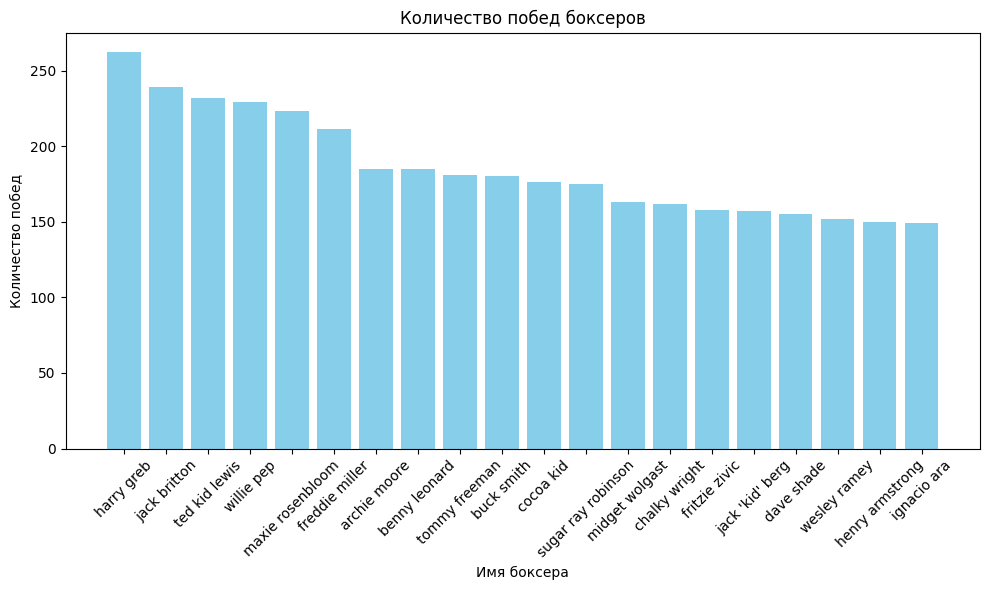

In [6]:
df_sorted = df_f.sort_values(by='wins', ascending=False).head(20)

# Создаем график
plt.figure(figsize=(10, 6))
plt.bar(df_sorted['name'], df_sorted['wins'], color='skyblue')
plt.xlabel('Имя боксера')
plt.ylabel('Количество побед')
plt.title('Количество побед боксеров')
plt.xticks(rotation=45)
plt.tight_layout()

# Топ бойцов с самым большим количеством побед составляют боксеры старой школы

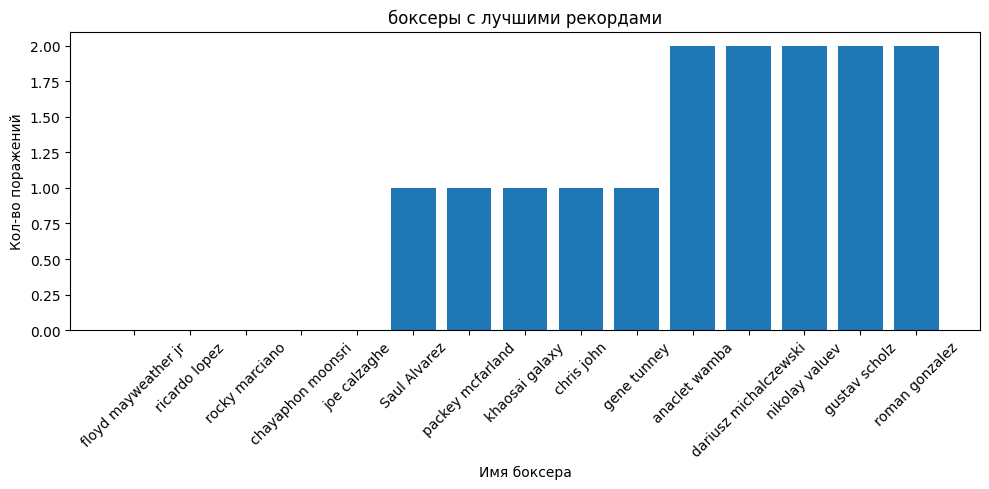

In [7]:
df_sort = df_f[(df_f['wins'] > 45 )].sort_values('looses',ascending=True).head(15)
plt.figure(figsize=(10,5))
plt.bar(df_sort['name'],df_sort['looses'])
plt.xlabel('Имя боксера')
plt.ylabel('Кол-во поражений')
plt.title('боксеры с лучшими рекордами')
plt.xticks(rotation=45)
plt.tight_layout()

# Всего лишь 5 боксеров за все время имеют безупречный рекорд при большом количестве побед

# Почистим данные

In [8]:
#Соеденим данные  в поле name без пробелов
df_f['name'] = df_f['name'].apply(lambda x: str(x).replace(' ','').upper())
df_f = df_f[(df_f['wins']!=0)]
df_f = df_f.drop_duplicates(subset=['name'])
df_f.head(5)

,name,wins,looses,draws,ko_rate,stance,age,height,reach
3,SAULALVAREZ,54,1,2,63.2%,Orthodox,32,5.74 ft (1.75 m),70.47 inches (179 cm)
4,DMITRIBIVOL,23,0,0,52.4%,Orthodox,33,6.04 ft (1.83 m),72.00 inches (183 cm)
5,JAIOPETAIA,25,0,0,76.92,Southpaw,33,6.2 ft (1.88 m),76.0 inches (193 cm)
6,ERICBUTTERBEAN,77,10,4,74.00,Orthodox,33,6.2 ft (1.88 m),76.0 inches (193 cm)
7,JACKMASSEY,22,2,0,54.55,Orthodox,31,6.4 ft (1.93 m),76.0 inches (193 cm)


In [9]:
#Прочтем данные о популярных боях
df = pd.read_csv(f'{FILE_PATH}/popular_matches.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 19 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        153 non-null    object 
 1   place                                       153 non-null    object 
 2   opponent_1                                  153 non-null    object 
 3   opponent_2                                  153 non-null    object 
 4   opponent_1_estimated_punch_power            153 non-null    int64  
 5   opponent_2_estimated_punch_power            153 non-null    int64  
 6   opponent_1_estimated_punch_resistance       151 non-null    float64
 7   opponent_2_estimated_punch_resistance       145 non-null    float64
 8   opponent_1_estimated_ability_to_take_punch  152 non-null    float64
 9   opponent_2_estimated_ability_to_take_punch  146 non-null    float64
 10  opponent_1_rou

In [10]:
#Продолжаем очистку.Место проведения боя нам не нужно
df = df.drop(['place'],axis=1)

# Заменим все 0 на Nan для грамотной обработки. Цифра 0 критичны в местах,где есть рекорд бойца. (напр. если у бойца 0 поражений и мы заменим на NaN -это будет некорректно)

In [11]:

print(df[df['opponent_1_estimated_punch_resistance']==0].shape)
print(df[df['opponent_2_has_been_ko_percentage'] == 0].shape)
print(df[df['opponent_1_estimated_punch_resistance'] == 0].shape)
print(df[df['opponent_2_estimated_punch_resistance'] == 0].shape)
print(df[df['opponent_1_estimated_ability_to_take_punch'] == 0].shape)
print(df[df['opponent_2_estimated_ability_to_take_punch'] == 0].shape)
print(df[df['opponent_2_rounds_boxed'] == 0].shape)
print(df[df['opponent_1_round_ko_percentage'] == 0].shape)
print(df[df['opponent_2_round_ko_percentage'] == 0].shape)
print(df[df['opponent_1_has_been_ko_percentage'] == 0].shape)
print(df[df['opponent_2_has_been_ko_percentage'] == 0].shape)
print(df[df['opponent_1_avg_weight'] == 0].shape)
print(df[df['opponent_2_avg_weight'] == 0].shape)



(3, 18)
(77, 18)
(3, 18)
(3, 18)
(3, 18)
(3, 18)
(3, 18)
(4, 18)
(4, 18)
(77, 18)
(77, 18)
(7, 18)
(7, 18)


In [12]:
df['opponent_1_estimated_punch_resistance'] = df['opponent_1_estimated_punch_resistance'].replace(0, np.nan)
df['opponent_2_has_been_ko_percentage'] = df['opponent_2_has_been_ko_percentage'].replace(0,np.nan)
df['opponent_1_estimated_punch_resistance'] =df['opponent_1_estimated_punch_resistance'].replace(0,np.nan)
df['opponent_2_estimated_punch_resistance'] = df['opponent_2_estimated_punch_resistance'].replace(0,np.nan)
df['opponent_1_estimated_ability_to_take_punch'] = df['opponent_1_estimated_ability_to_take_punch'].replace(0,np.nan)
df['opponent_2_estimated_ability_to_take_punch'] = df['opponent_2_estimated_ability_to_take_punch'].replace(0,np.nan)
df['opponent_2_rounds_boxed'] = df['opponent_2_rounds_boxed'].replace(0,np.nan)
df['opponent_1_round_ko_percentage'] = df['opponent_1_round_ko_percentage'].replace(0,np.nan)
df['opponent_2_round_ko_percentage'] = df['opponent_2_round_ko_percentage'].replace(0,np.nan)
df['opponent_1_has_been_ko_percentage'] = df['opponent_1_has_been_ko_percentage'].replace(0,np.nan)
df['opponent_2_has_been_ko_percentage'] = df['opponent_2_has_been_ko_percentage'].replace(0,np.nan)
df['opponent_1_avg_weight'] = df['opponent_1_avg_weight'].replace(0,np.nan)
df['opponent_2_avg_weight'] = df['opponent_2_avg_weight'].replace(0,np.nan)

In [13]:
print(df[df['opponent_1_estimated_punch_resistance']==0].shape)
print(df[df['opponent_2_has_been_ko_percentage'] == 0].shape)
print(df[df['opponent_1_estimated_punch_resistance'] == 0].shape)
print(df[df['opponent_2_estimated_punch_resistance'] == 0].shape)
print(df[df['opponent_1_estimated_ability_to_take_punch'] == 0].shape)
print(df[df['opponent_2_estimated_ability_to_take_punch'] == 0].shape)
print(df[df['opponent_2_rounds_boxed'] == 0].shape)
print(df[df['opponent_1_round_ko_percentage'] == 0].shape)
print(df[df['opponent_2_round_ko_percentage'] == 0].shape)
print(df[df['opponent_1_has_been_ko_percentage'] == 0].shape)
print(df[df['opponent_2_has_been_ko_percentage'] == 0].shape)
print(df[df['opponent_1_avg_weight'] == 0].shape)
print(df[df['opponent_2_avg_weight'] == 0].shape)

(0, 18)
(0, 18)
(0, 18)
(0, 18)
(0, 18)
(0, 18)
(0, 18)
(0, 18)
(0, 18)
(0, 18)
(0, 18)
(0, 18)
(0, 18)




> Преобразуем вердикт в результат решения судей







In [14]:
def res(x):
    for i in str(x).split(' '):
        if "UD" in i:
            return "UD"
        elif "RTD" in i:
            return "RTD"
        elif "KO" in i:
            return "KO"
        elif "TKO" in i:
            return "TKO"
        elif "SD" in i:
            return "SD"
        elif "MD" in i:
            return "MD"
        elif "PTS" in i:
            return "PTS"
        elif "DQ" in i:
            return "DQ"


df['result'] = df['verdict'].apply(res)



> Проведем нормализацию данных,для удобства обучения и анализа.



In [15]:
df_f['age'] = pd.to_numeric(df_f['age'], errors='coerce')
df_f['height'] = df_f['height'].apply(lambda x: str(x).split(sep=(' '))[0])
df_f['reach'] = df_f['reach'].apply(lambda x: str(x).split(sep=(' '))[0])

In [16]:
def inches_to_meters(inches):
  if inches == np.NaN:
    return np.nan
  elif inches == 'Unknown':
    return np.nan
  else:
    return round((np.float64(inches) * 0.0254) * 100)

def foots_to_sm(foots):
  if foots == np.NaN:
    return np.nan
  elif foots == 'Unknown':
    return np.nan
  else:
    return round((np.float64(foots) * 30.48))

df_f['height'] = df_f['height'].apply(foots_to_sm)
df_f['reach'] = df_f['reach'].apply(inches_to_meters)

In [17]:
df['verdict'] = df['verdict'].apply(lambda x: str(x).split(sep=' ')[0].upper())

In [18]:
df_f['ko_rate'] = df_f['ko_rate'].apply(lambda x: str(x).split(sep='%')[0])
df_f['ko_rate'] = df_f['ko_rate'].apply(lambda x: np.float64(x))
df['opponent_1_estimated_punch_power'] = df['opponent_1_estimated_punch_power'].apply(lambda x: np.float64(x))
df['opponent_2_estimated_punch_power'] = df['opponent_2_estimated_punch_power'].apply(lambda x: np.float64(x))
df['opponent_1_rounds_boxed'] = df['opponent_1_rounds_boxed'].apply(lambda x: np.float64(x))
df_f['height'] = df_f['height'].apply(lambda x: np.float64(x) if x !='Unknown' else np.nan)
df_f['reach'] = df_f['reach'].apply(lambda x: np.float64(x) if x !='Unknown' else np.nan )

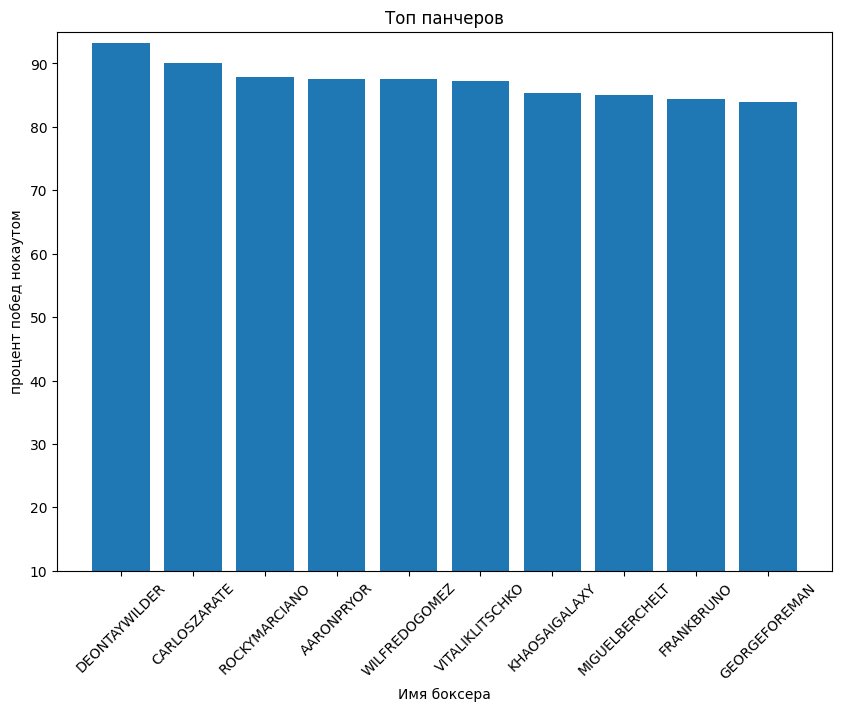

In [19]:

plt.figure(figsize=(10,7))
df_ko = df_f[(df_f['wins'] > 30)].sort_values('ko_rate',ascending=False).head(10)
plt.bar(df_ko['name'],df_ko['ko_rate'])
plt.ylim(10,95)
plt.xlabel('Имя боксера')
plt.ylabel('процент побед нокаутом')
plt.title('Топ панчеров')
plt.xticks(rotation=45)
plt.show()

In [20]:
df['opponent_1'] = df['opponent_1'].apply(lambda x: str(x).replace(' ','').upper() if x != "JR" else x == str(x).split(sep=('JR')))
df['opponent_2'] = df['opponent_2'].apply(lambda x: str(x).replace(' ','').upper() if x != "JR" else x == str(x).split(sep=('JR')))
df.head(5)

,date,opponent_1,opponent_2,opponent_1_estimated_punch_power,opponent_2_estimated_punch_power,opponent_1_estimated_punch_resistance,opponent_2_estimated_punch_resistance,opponent_1_estimated_ability_to_take_punch,opponent_2_estimated_ability_to_take_punch,opponent_1_rounds_boxed,opponent_2_rounds_boxed,opponent_1_round_ko_percentage,opponent_2_round_ko_percentage,opponent_1_has_been_ko_percentage,opponent_2_has_been_ko_percentage,opponent_1_avg_weight,opponent_2_avg_weight,verdict,result
0,31 August 2019,VASYLLOMACHENKO,LUKECAMPBELL,72.0,72.0,73.9,60.5,78.0,73.0,119.0,130.0,8.40,12.31,NaN,NaN,127.11,135.24,LOMACHENKO,UD
1,19 September 2019,ORLANDOFIORDIGIGLIO,SAMEGGINGTON,59.0,59.0,55.4,54.5,68.0,66.0,200.0,177.0,6.50,8.47,3.03,6.25,152.50,148.93,EGGINGTON,KO
2,5 October 2019,GENNADYGOLOVKIN,SERGIYDEREVYANCHENKO,82.0,82.0,68.0,63.3,84.0,75.0,200.0,81.0,17.50,12.35,NaN,NaN,159.66,164.04,GOLOVKIN,UD
3,12 October 2019,CHAZZWITHERSPOON,OLEKSANDRUSYK,69.0,69.0,59.6,68.9,79.0,80.0,182.0,125.0,15.93,9.60,4.76,NaN,292.71,200.10,USYK,RTD
4,27 September 2019,EBENEZERTETTEH,DANIELDUBOIS,46.0,46.0,NaN,44.4,50.0,69.0,38.0,39.0,23.68,30.77,NaN,NaN,178.67,230.38,DUBOIS,KO


# Соединим наши таблицы популярных событий и с таблицей бойцов

In [21]:
df_f_1 = df_f.add_suffix('_1') # добавим суффикс 1 ко всем полям датасета бойцов(напр. name_1, weight_1)
df_f_1 = df_f_1.rename(columns={'name_1' : 'opponent_1'}) #Заменим поле name_1 ( с суффиксом который мы добавляли) на такое же название как в основной таблице

df_f_2 = df_f.add_suffix('_2') # Выполняем тоже самое со 2ым оппонентом,у нас получится 2 таблицы opponent_1 и opponent_2 в доп. таблице и по ним будем обьеденять таблицы ,чтобы данные распределились верно
df_f_2 = df_f_2.rename(columns={'name_2' : 'opponent_2'})

df_merged_1 = df.merge(df_f_1,on='opponent_1',how='left')
df_final = df_merged_1.merge(df_f_2,on='opponent_2',how='left')

df_final.head(10)

,date,opponent_1,opponent_2,opponent_1_estimated_punch_power,opponent_2_estimated_punch_power,opponent_1_estimated_punch_resistance,opponent_2_estimated_punch_resistance,opponent_1_estimated_ability_to_take_punch,opponent_2_estimated_ability_to_take_punch,opponent_1_rounds_boxed,...,height_1,reach_1,wins_2,looses_2,draws_2,ko_rate_2,stance_2,age_2,height_2,reach_2
0,31 August 2019,VASYLLOMACHENKO,LUKECAMPBELL,72.0,72.0,73.9,60.5,78.0,73.0,119.0,...,168.0,166.0,20.0,3.0,0.0,66.7,Southpaw,34.0,175.0,180.0
1,19 September 2019,ORLANDOFIORDIGIGLIO,SAMEGGINGTON,59.0,59.0,55.4,54.5,68.0,66.0,200.0,...,NaN,NaN,28.0,7.0,0.0,48.6,Orthodox,28.0,180.0,NaN
2,5 October 2019,GENNADYGOLOVKIN,SERGIYDEREVYANCHENKO,82.0,82.0,68.0,63.3,84.0,75.0,200.0,...,179.0,178.0,13.0,2.0,0.0,66.7,Orthodox,36.0,170.0,171.0
3,12 October 2019,CHAZZWITHERSPOON,OLEKSANDRUSYK,69.0,69.0,59.6,68.9,79.0,80.0,182.0,...,NaN,NaN,18.0,0.0,0.0,72.2,Southpaw,35.0,190.0,NaN
4,27 September 2019,EBENEZERTETTEH,DANIELDUBOIS,46.0,46.0,NaN,44.4,50.0,69.0,38.0,...,NaN,NaN,15.0,1.0,0.0,87.5,Orthodox,25.0,194.0,NaN
5,28 September 2019,SHAWNPORTER,ERROLSPENCEJR,66.0,66.0,63.8,62.3,80.0,77.0,219.0,...,170.0,177.0,26.0,0.0,0.0,77.8,Orthodox,32.0,178.0,183.0
6,13 September 2019,ZAURABDULLAEV,DEVINHANEY,64.0,64.0,58.4,47.0,72.0,73.0,60.0,...,175.0,NaN,24.0,0.0,0.0,57.7,Orthodox,23.0,NaN,NaN
7,14 September 2019,TYSONFURY,OTTOWALLIN,72.0,72.0,66.5,57.4,86.0,77.0,174.0,...,206.0,216.0,20.0,1.0,0.0,56.5,Southpaw,31.0,197.0,198.0
8,31 August 2019,ALEXANDERPOVETKIN,HUGHIEFURY,74.0,74.0,72.6,60.0,81.0,77.0,231.0,...,188.0,191.0,24.0,3.0,0.0,51.9,Orthodox,27.0,198.0,NaN
9,18 October 2019,ARTURBETERBIEV,OLEKSANDRGVOZDYK,88.0,88.0,68.4,67.5,81.0,78.0,52.0,...,184.0,185.0,17.0,1.0,0.0,77.8,Unknown,35.0,188.0,192.0


In [22]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 35 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        153 non-null    object 
 1   opponent_1                                  153 non-null    object 
 2   opponent_2                                  153 non-null    object 
 3   opponent_1_estimated_punch_power            153 non-null    float64
 4   opponent_2_estimated_punch_power            153 non-null    float64
 5   opponent_1_estimated_punch_resistance       148 non-null    float64
 6   opponent_2_estimated_punch_resistance       142 non-null    float64
 7   opponent_1_estimated_ability_to_take_punch  149 non-null    float64
 8   opponent_2_estimated_ability_to_take_punch  143 non-null    float64
 9   opponent_1_rounds_boxed                     153 non-null    float64
 10  opponent_2_rou



> Выполним преобразования соперников,результатов и стойки бойцов


1.   convert_opp преобразовывает поле вердикт ( если победил opponent_1,выставляется 0.0, если opponent_2, то 1.0
2.   convert_res преобразует поле результат ( Если бой завршен раньше отведенного времени, в таблице отражается 1.0 т.е досрочно ,если по решению судей ,то 0.0

3. convert_stance преобразует стойку бойца в 1.0 если Левша, в 0.0 если правша или неизвестно, т.к мы можем предположить,что большинство все же правши








In [23]:
def convert_opp(row):
    if row['verdict'] in row['opponent_1'] :
        return 0.0
    else:
        return 1.0



def convert_res(row):
    if row['result'] in ['UD', 'MD', 'SD']:
        return 0.0
    else:
        return 1.0
def convert_stance(row):
   stance_1 = str(row['stance_1'])  # Преобразуем в строку
   stance_2 = str(row['stance_2'])  # Преобразуем в строку
   if 'Orthodox' in stance_1 or 'Orthodox' in stance_2:
      return 0.0
   elif 'Southpaw' in stance_1 or 'Southpaw' in stance_2:
        return 1.0
   else:
        return np.nan

df_final['verdict'] = df_final.apply(convert_opp, axis=1)
df_final['result'] = df_final.apply(convert_res, axis=1)
df_final['stance_1'] = df_final.apply(convert_stance, axis=1)
df_final['stance_2'] = df_final.apply(convert_stance, axis=1)



> Смотрим рез-тат преобразования на примере нескольких боев

напр. Lomachenko-Campbell бой завершился по очкам и победил Lomachenko,оба бойца левши и мы видим отражение результатов в соответствующей таблице



In [24]:
df_final[['opponent_1','opponent_2','verdict','result','stance_1','stance_2']]

,opponent_1,opponent_2,verdict,result,stance_1,stance_2
0,VASYLLOMACHENKO,LUKECAMPBELL,0.0,0.0,1.0,1.0
1,ORLANDOFIORDIGIGLIO,SAMEGGINGTON,1.0,1.0,0.0,0.0
2,GENNADYGOLOVKIN,SERGIYDEREVYANCHENKO,0.0,0.0,0.0,0.0
3,CHAZZWITHERSPOON,OLEKSANDRUSYK,1.0,1.0,1.0,1.0
4,EBENEZERTETTEH,DANIELDUBOIS,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...
148,DEONTAYWILDER,TYSONFURY,1.0,1.0,0.0,0.0
149,SCOTTQUIGG,JONOCARROLL,1.0,1.0,0.0,0.0
150,JOEHUGHES,SAMMAXWELL,1.0,0.0,NaN,NaN
151,VASYLLOMACHENKO,TEOFIMOLOPEZ,1.0,0.0,1.0,NaN


# Подготоваливаем данные и обучаем модель

In [25]:
df_final_t = df_final.drop(['opponent_1','opponent_2','date','verdict'],axis=1) #Для определения победителя
df_final_t1 = df_final.drop(['opponent_1','opponent_2','date','result'],axis=1) #Для определения рез-тата

In [26]:
df_final_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 31 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   opponent_1_estimated_punch_power            153 non-null    float64
 1   opponent_2_estimated_punch_power            153 non-null    float64
 2   opponent_1_estimated_punch_resistance       148 non-null    float64
 3   opponent_2_estimated_punch_resistance       142 non-null    float64
 4   opponent_1_estimated_ability_to_take_punch  149 non-null    float64
 5   opponent_2_estimated_ability_to_take_punch  143 non-null    float64
 6   opponent_1_rounds_boxed                     153 non-null    float64
 7   opponent_2_rounds_boxed                     123 non-null    float64
 8   opponent_1_round_ko_percentage              125 non-null    float64
 9   opponent_2_round_ko_percentage              131 non-null    float64
 10  opponent_1_has



# > Расположим 3 примера с разными моделями классификации (частично.)
Победитель:


*   XGBoost справился с задачей на 85.25 %
*   Random Forest 87.5%
*   HistGradientBoostingClassifier 93.75%

Результат:

*   XGBoost справился с задачей на 78.26 %
*   Random Forest 87.5%
*   HistGradientBoostingClassifier 93.75%








In [27]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
x_train,x_test,y_train,y_test = train_test_split(df_final_t,df_final['verdict'],test_size=0.4,random_state=7)
model = XGBClassifier(max_depth=2, learning_rate=0.5, n_estimators=50,
min_child_weight=0.2)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test,y_pred)
print(f'Точность победителя : {round(accuracy*100,2)} %')


print('-------------------------------------')


x_train1,x_test1,y_train1,y_test1 = train_test_split(df_final_t1,df_final['result'],test_size=0.3,random_state=7)
model1 = XGBClassifier(max_depth=2, learning_rate=0.5, n_estimators=50,
min_child_weight=0.2)
model1.fit(x_train1,y_train1)
y_pred1 = model1.predict(x_test1)
accuracy1 = accuracy_score(y_test1,y_pred1)
print(f'Точность результата : {round(accuracy1*100,2)} %')

Точность победителя : 82.26 %
-------------------------------------
Точность результата : 71.74 %


Text(0.5, 155.62847222222217, 'Предсказанные метки')

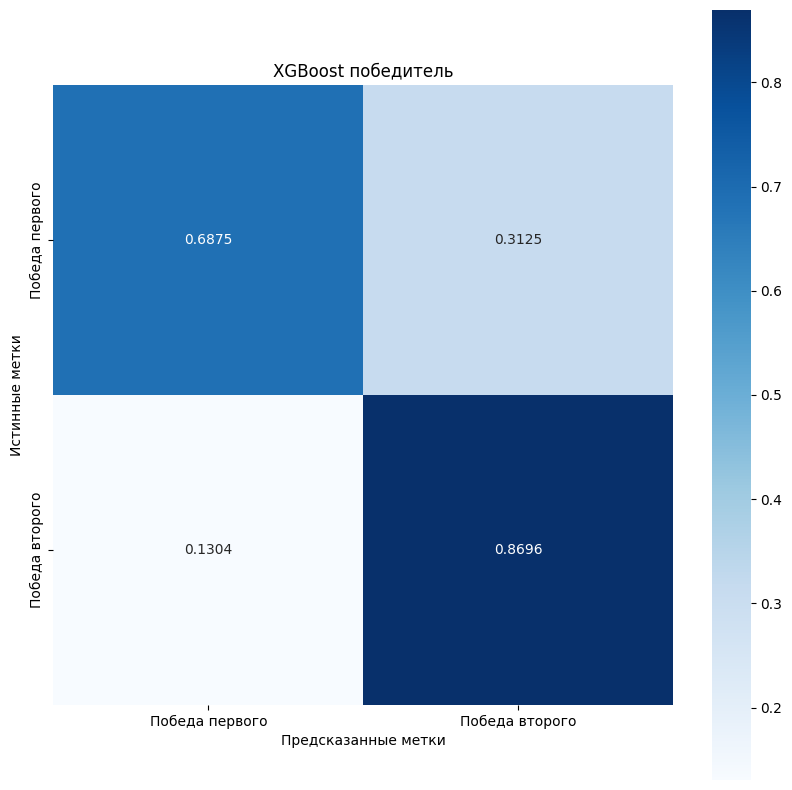

In [28]:
plt.figure(figsize=(10,10))
confusion = confusion_matrix(y_test,y_pred)
confusion_normalized = confusion / confusion.sum(axis=1,keepdims=True)
ax = sns.heatmap(confusion_normalized,xticklabels=['Победа первого','Победа второго'],yticklabels=['Победа первого','Победа второго'],cmap='Blues',annot=True,fmt='.4f',square=True)
plt.title("XGBoost победитель")
plt.ylabel("Истинные метки")
plt.xlabel("Предсказанные метки")

Text(0.5, 155.72222222222217, 'Предсказанные метки')

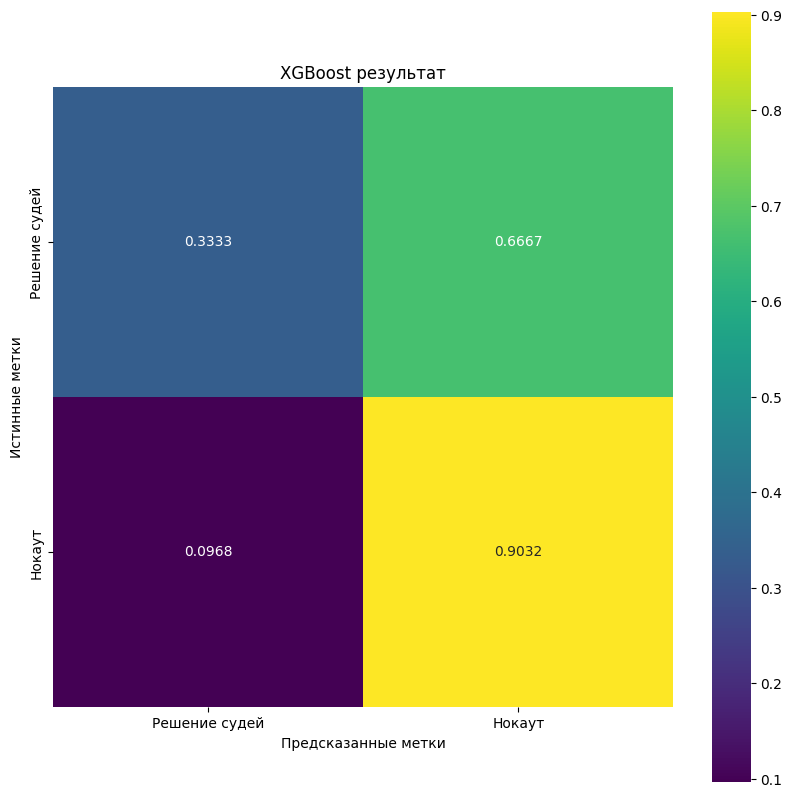

In [29]:
plt.figure(figsize=(10,10))
confusion = confusion_matrix(y_test1,y_pred1)
confusion_normalized = confusion / confusion.sum(axis=1,keepdims=True)
ax = sns.heatmap(confusion_normalized,xticklabels=['Решение судей','Нокаут'],yticklabels=['Решение судей','Нокаут'],cmap='viridis',annot=True,fmt='.4f',square=True)
plt.title("XGBoost результат")
plt.ylabel("Истинные метки")
plt.xlabel("Предсказанные метки")

In [30]:
print('-------------------------------------')
x_train1, x_test1, y_train1, y_test1 = train_test_split(df_final_t1, df_final['result'], test_size = 0.4, random_state = 7)
model1 = RandomForestClassifier(n_estimators = 1000, max_depth = 2, criterion = 'entropy', random_state = 3)
model1.fit(x_train1, y_train1)
y_pred1 = model1.predict(x_test1)
accuracy1 = accuracy_score(y_test1, y_pred1)
print(f'Точность результата боя : {round(accuracy*100,2)} %')

-------------------------------------
Точность результата боя : 82.26 %


Text(0.5, 155.62847222222217, 'Предсказанные метки')

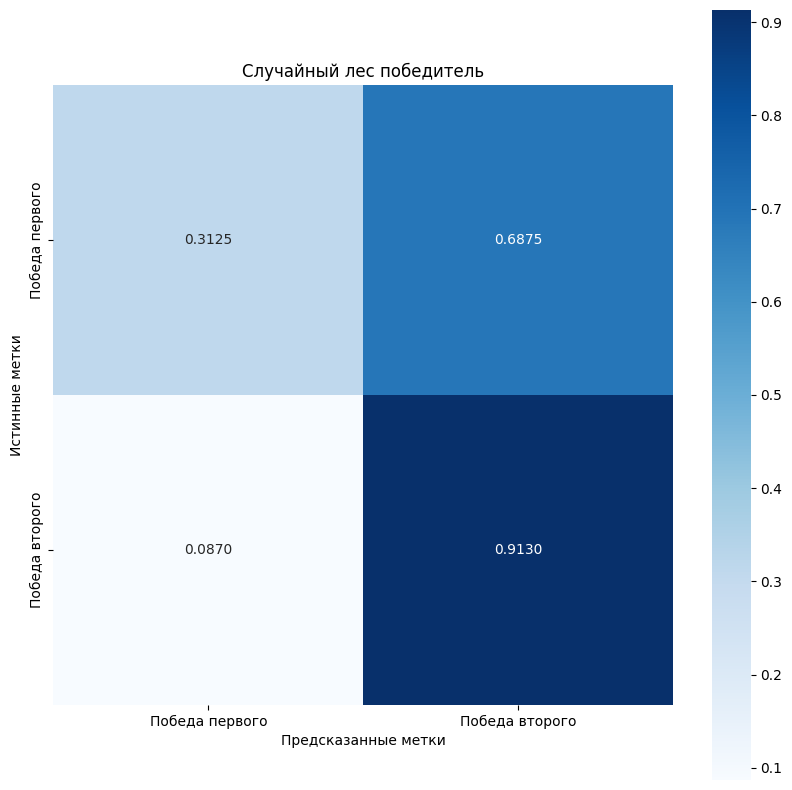

In [31]:
plt.figure(figsize=(10,10))
confusion = confusion_matrix(y_test1,y_pred1)
confusion_normalized = confusion / confusion.sum(axis=1,keepdims=True)
ax = sns.heatmap(confusion_normalized,xticklabels=['Победа первого','Победа второго'],yticklabels=['Победа первого','Победа второго'],cmap='Blues',annot=True,fmt='.4f',square=True)
plt.title("Случайный лес победитель")
plt.ylabel("Истинные метки")
plt.xlabel("Предсказанные метки")

Text(0.5, 155.72222222222217, 'Предсказанные метки')

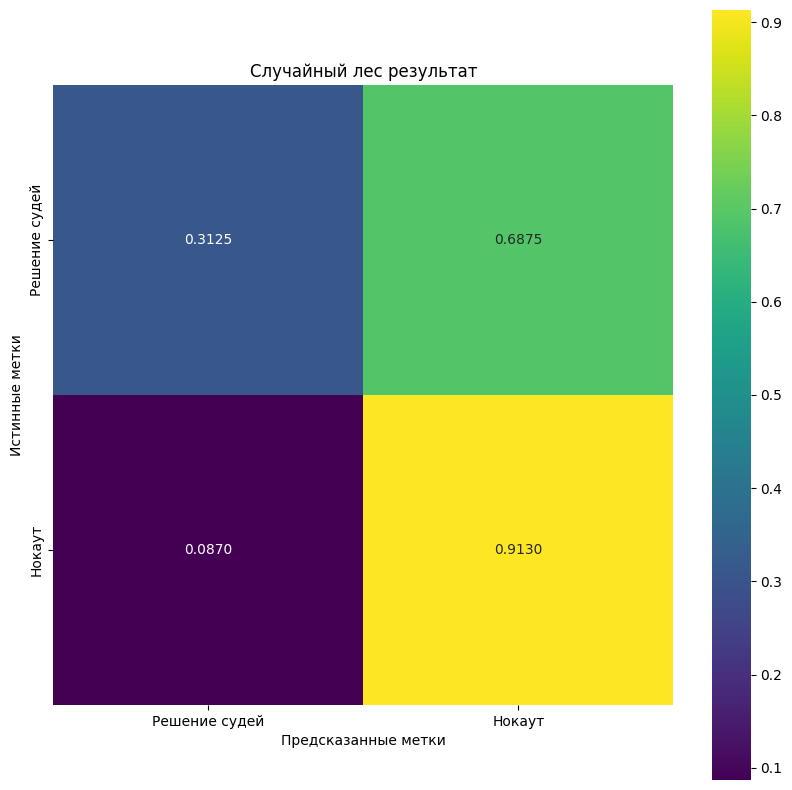

In [32]:
plt.figure(figsize=(10,10))
confusion = confusion_matrix(y_test1,y_pred1)
confusion_normalized = confusion / confusion.sum(axis=1,keepdims=True)
ax = sns.heatmap(confusion_normalized,xticklabels=['Решение судей','Нокаут'],yticklabels=['Решение судей','Нокаут'],cmap='viridis',annot=True,fmt='.4f',square=True)
plt.title("Случайный лес результат")
plt.ylabel("Истинные метки")
plt.xlabel("Предсказанные метки")

In [33]:
from sklearn.ensemble import HistGradientBoostingClassifier
X_train, X_test, y_train, y_test = train_test_split(df_final_t, df_final['verdict'], test_size=0.1, random_state=7)

# Создание и обучение модели
model = HistGradientBoostingClassifier(loss='log_loss',learning_rate=0.1,max_iter=50,max_leaf_nodes=30)
model.fit(X_train, y_train)

# Предсказание и оценка точности
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Точность определения победителя: {round(accuracy*100,2)} %')



Точность определения победителя: 87.5 %


In [34]:
print('-------------------------------------')
X_train1, X_test1, y_train1, y_test1 = train_test_split(df_final_t1, df_final['result'], test_size=0.3, random_state=7)

# Создание и обучение модели
model1 = HistGradientBoostingClassifier(loss='log_loss',learning_rate=0.05,max_iter=50,max_leaf_nodes=30)
model1.fit(X_train1, y_train1)

# Предсказание и оценка точности
y_pred1 = model1.predict(X_test1)
accuracy1 = accuracy_score(y_test1, y_pred1)
print(f'Точность определения результата: {round(accuracy*100,2)} %')

-------------------------------------
Точность определения результата: 87.5 %


Text(0.5, 155.62847222222217, 'Предсказанные метки')

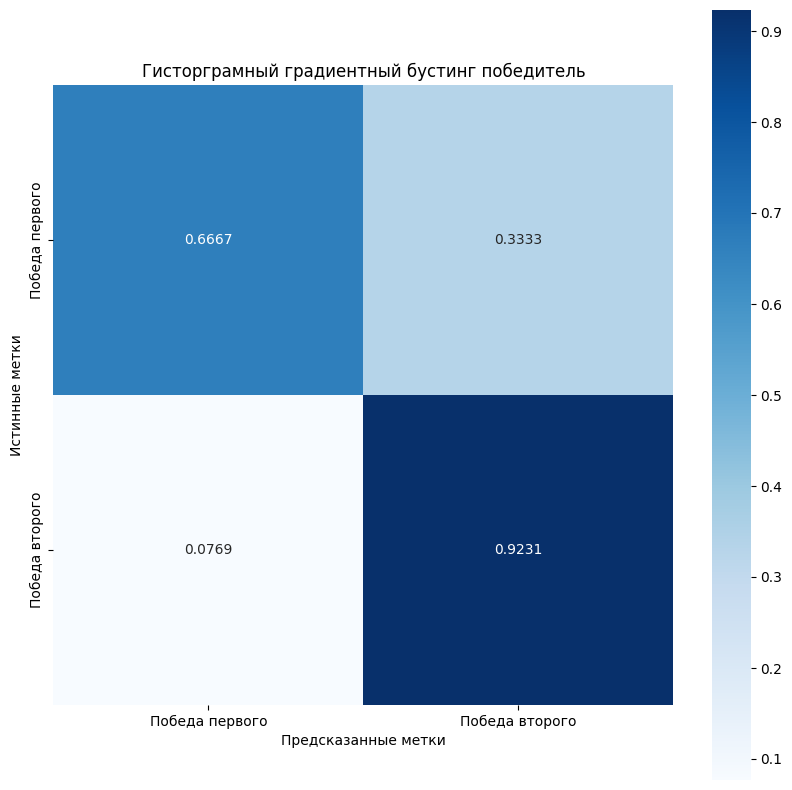

In [35]:
plt.figure(figsize=(10,10))
confusion = confusion_matrix(y_test,y_pred)
confusion_normalized = confusion / confusion.sum(axis=1,keepdims=True)
ax = sns.heatmap(confusion_normalized,xticklabels=['Победа первого','Победа второго'],yticklabels=['Победа первого','Победа второго'],cmap='Blues',annot=True,fmt='.4f',square=True)
plt.title("Гисторграмный градиентный бустинг победитель")
plt.ylabel("Истинные метки")
plt.xlabel("Предсказанные метки")

Text(0.5, 155.72222222222217, 'Предсказанные метки')

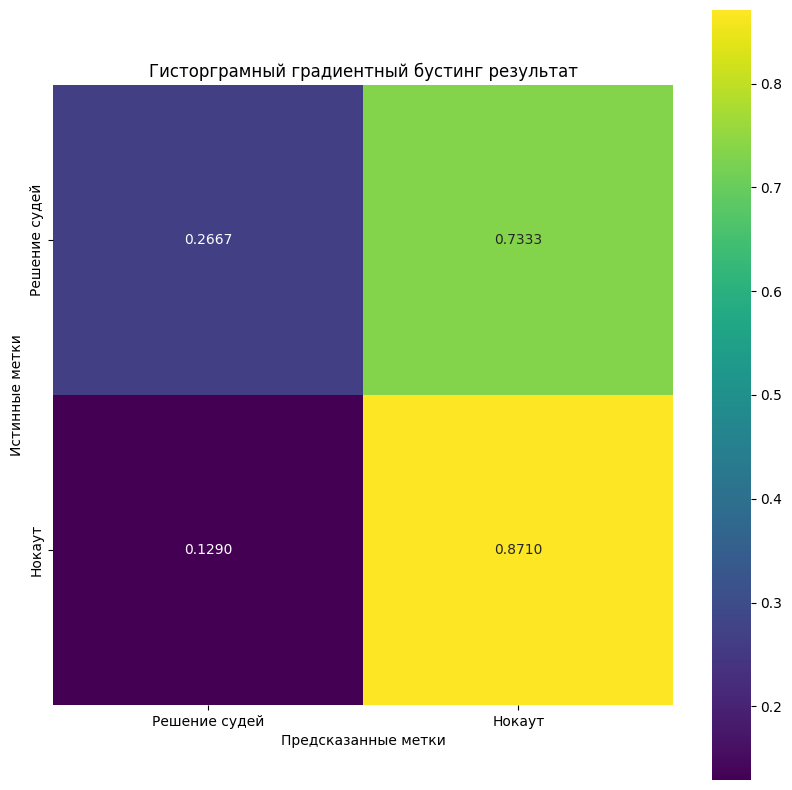

In [36]:
plt.figure(figsize=(10,10))
confusion = confusion_matrix(y_test1,y_pred1)
confusion_normalized = confusion / confusion.sum(axis=1,keepdims=True)
ax = sns.heatmap(confusion_normalized,xticklabels=['Решение судей','Нокаут'],yticklabels=['Решение судей','Нокаут'],cmap='viridis',annot=True,fmt='.4f',square=True)
plt.title("Гисторграмный градиентный бустинг результат")
plt.ylabel("Истинные метки")
plt.xlabel("Предсказанные метки")